# Residue Exchange Profiler v0.1.1
REP allows researchers to investigate the flip-flop behavior between any two groups A and B in the presence of a neutal label C. All you need are some traces whith assigned labels over time. All other labels than A or B are relabeled as C and the flip-flop analysis is automatically performed. Making it trivial to get insights in flip flop moements, rates and durations. This information can be used to highlight interesting events in huge data sets, or to gain an understanding about the dynamics between labels.

In [20]:
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cython

In [21]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [22]:
%%cython

import numpy as np

cimport numpy as cnp
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
def process_traces_cython(cnp.ndarray[cnp.int8_t, ndim=2] traces, verbose):
    """
    Process traces to detect transitions between -1 and 1 with zero-runs in between.
    
    Args:
        traces: numpy array of shape (n_frames, n_traces) with values in {-1, 0, 1}
    
    Returns:
        List of lists, one per trace, containing tuples of (start, stop, duration, sign, trace_id)
        where sign is the destination value (-1 or 1)
    """
    cdef int n_frames = traces.shape[0]
    cdef int n_traces = traces.shape[1]
    cdef int i, j, val, duration
    cdef cnp.ndarray[cnp.int8_t, ndim=1] last_nonzero = np.zeros(n_traces, dtype=np.int8)
    cdef cnp.ndarray[cnp.int32_t, ndim=1] zero_start = np.full(n_traces, -1, dtype=np.int32)
    
    # Results as a list of lists
    results = [[] for _ in range(n_traces)]
    
    for i in range(n_frames):
        if verbose: 
            if i % 10000 == 0:
                print(f'Frame: {i+1}/{n_frames}'.ljust(25), end='\r')
        
        for j in range(n_traces):
            val = traces[i, j]
            
            if val == 0:
                if last_nonzero[j] != 0 and zero_start[j] == -1:
                    zero_start[j] = i - 1
            
            elif val == -1 or val == 1:
                if last_nonzero[j] != 0 and last_nonzero[j] != val and zero_start[j] == -1:
                    results[j].append((i-1, i, 0, int(val), j))
                
                elif zero_start[j] != -1:
                    if last_nonzero[j] != val:
                        duration = i - zero_start[j] - 1
                        results[j].append((int(zero_start[j]), i, duration, int(val), j))
                    zero_start[j] = -1
                
                last_nonzero[j] = val
    if verbose: print(f'Frame: {i+1}/{n_frames}'.ljust(25))

    # Convert output to array shapde as start, stop, duration, sign, trace_id
    all_flips = []
    for flips in results:
        if len(flips):
            all_flips += flips
    return np.array(all_flips)

In [37]:
class ResidueExchangeAnalysis:
    """
    Analysis class for tracking exchange/flips in particle traces between segment ID A and B.

    This is a generalization of lipid flip-flops between two leaflets.
    
    Usage:
        analysis = ResidueExchangeAnalysis(segmentation, segment_A=1, segment_B=2)
        analysis.compute()
        analysis.plot()
    """
    
    def __init__(self, segmentation, segment_A=1, segment_B=2, 
                 blib_processing=True, dt=1, verbose=True):
        """
        Initialize the analysis.
        
        Parameters
        ----------
        segmentation : np.ndarray
            Segmentation data with shape (n_frames, n_traces)
        segment_A : int
            Segment ID for the first segment
        segment_B : int
            Segment ID for the second segment
        blib_processing : bool
            Whether to apply blib smearing to smooth out temporary segment losses (default=True)
        dt : int
            The amount of time in ps in between frames (default=1)
        """
        self._segmentation = segmentation
        self._segment_A = segment_A
        self._segment_B = segment_B
        self._blib_processing = blib_processing
        self._dt = dt
        self._verbose = verbose
        
        # Results (populated by compute())
        self._masked_segmentation = None
        self._valid_mask = None
        self._flips = None
        self._flip_counts = None
        self._AB = None
        self._BA = None
        self._cumulative_AB = None
        self._cumulative_BA = None
        self._cumulative_net_AB = None
        self._computed = False

    @property
    def segmentation(self):
        """Input segmentation array"""
        return self._segmentation
    
    @property
    def segment_A(self):
        """Input segment label set to A (1)"""
        return self._segment_A

    @property
    def segment_B(self):
        """Input segment label set to B (-1)"""
        return self._segment_B

    @property
    def blib_processing(self):
        """Input boolean, True if blib processing was used"""
        return self._blib_processing

    @property
    def dt(self):
        """Input timestep in ps (e.g. for MDAnalysis u.trajectory.dt)"""
        return self._dt
        
    @property
    def n_residues(self):
        """Number of residues in selection"""
        return self.segmentation.shape[1]
    
    @property
    def n_frames(self):
        """Number of frames in trajectory"""
        return self.segmentation.shape[0]

    @property
    def masked_segmentation(self):
        """
        Copy of segmentation array, where A=1, B=-1, Other=0 if A and B in a
        frame, else all values in the frame are set to 0
        """
        if not self._computed:
            raise RuntimeError("No results. Run .compute() first.")

        return self._masked_segmentation

    @property
    def valid_mask(self):
        """
        Boolean array of size n_frames, True if segment A and B in frame 
        """
        if not self._computed:
            raise RuntimeError("No results. Run .compute() first.")

        return self._valid_mask

    @property
    def flips(self):
        """
        Array of (:, [start, stop, duration, sign, trace_id])
        """
        if not self._computed:
            raise RuntimeError("No results. Run .compute() first.")
        
        return self._flips

    @property
    def flip_counts(self):
        """Array of (:, [trace_id, flip_count])"""
        if not self._computed:
            raise RuntimeError("No results. Run .compute() first.")

        return self._flip_counts
        
    @property
    def AB(self):
        """
        Array of the amount of flips A->B per frame over time 
        """
        if not self._computed:
            raise RuntimeError("No results. Run .compute() first.")

        return self._AB

    @property
    def BA(self):
        """
        Array of the amount of flips B->A per frame over time
        """
        if not self._computed:
            raise RuntimeError("No results. Run .compute() first.")

        return self._BA

    @property
    def cumulative_AB(self):
        """
        Array of the cumulative amount of flips A->B per frame over time
        """
        if not self._computed:
            raise RuntimeError("No results. Run .compute() first.")

        return self._cumulative_AB

    @property
    def cumulative_BA(self):
        """
        Array of the cumulative amount of flips B->A per frame over time
        """
        if not self._computed:
            raise RuntimeError("No results. Run .compute() first.")

        return self._cumulative_BA

    @property
    def cumulative_net_AB(self):
        """Array of cumulativeAB - cumulativeBA"""
        if not self._computed:
            raise RuntimeError("No results. Run .compute() first.")

        return self._cumulative_net_AB
    
    def _apply_segment_mask(self, segments):
        """
        Apply segment masking: convert segment IDs to 1 and -1, 
        everything else to 0.
        """
        if self._verbose: print("Applying segment masks...")
        segment_A_mask = segments == self.segment_A
        segment_B_mask = segments == self.segment_B
        
        masked = np.zeros_like(segments, dtype=np.int8)
        masked[segment_A_mask] = 1
        masked[segment_B_mask] = -1
        return masked

    def _mask_frames_without_segments(self, segments):
        """
        Set all residues to 0 in frames where either segment A or B
        does not appear at all (to avoid artifacts).
        
        Returns
        -------
        segments : np.ndarray
            Masked segments array
        valid_mask : np.ndarray
            Boolean array indicating frames where both segments exist
        """
        if self._verbose: print("Masking frames without both segments...")
        # Boolean arrays per frame
        has_A = np.any(segments == 1, axis=1)
        has_B = np.any(segments == -1, axis=1)
        valid = has_A & has_B
    
        # Frames where either A or B is missing → zero out
        segments[~valid, :] = 0
        return segments, valid
    
    def _calculate_flip_timeseries(self, raw_flips):
        """
        Convert raw flip data (start, stop, duration, sign, trace_id) into
        per-frame flip counts for AB and BA.
        
        Parameters
        ----------
        raw_flips : np.ndarray
            Array of shape (n_flips, 5) with columns:
            (start, stop, duration, sign, trace_id)
        
        Returns
        -------
        AB, BA : np.ndarray
            Per-frame flip counts (length = n_frames - 1)
        """
        if self._verbose: print("Calculating flip time series...")
        n_frames = self.n_frames
        
        # Initialize arrays (one less frame because flips happen between frames)
        AB = np.zeros(n_frames - 1, dtype=np.float64)
        BA = np.zeros(n_frames - 1, dtype=np.float64)
        
        if len(raw_flips) == 0:
            return AB, BA
        
        # Extract columns
        start_frames = raw_flips[:, 0].astype(int)
        stop_frames = raw_flips[:, 1].astype(int)
        durations = raw_flips[:, 2].astype(int)
        signs = raw_flips[:, 3].astype(int)
        
        for i in range(len(raw_flips)):
            start = start_frames[i]
            stop = stop_frames[i]
            duration = durations[i]
            sign = signs[i]
            
            if sign == -1:
                # Started from A (1) and ended at B (-1)
                AB[start] += 1
            elif sign == 1:
                # Started from B (-1) and ended at A (1)
                BA[start] += 1

        return AB, BA
    
    def _smear_blib_signals(self, AB, BA, valid_mask):
        """
        Smear flip signals over frames where segments are temporarily lost (blibs).
        
        The last non-blibbed flip value is smeared over the blib.
        Blib smearing preserves total flip count whilst making the time series continuous.
    
        Parameters
        ----------
        AB, BA : np.ndarray
            Instantaneous flip counts per frame.
    
        Returns
        -------
        AB_smooth, BA_smooth,  : np.ndarray
            Smoothed flip counts
        cumulative_AB, cumulative_BA : np.ndarray
            Cumulative flip counts
        cumulative_net_AB : np.ndarray
            Cumulative net AB flips
        """
        if self._verbose: print("Smearing blib signals...")
        
        def smear_signal(y):
            y_smooth = np.zeros_like(y, dtype=float)
            n = len(y)
            i = 0
            while i < n:
                if valid_mask[i]:
                    y_smooth[i] = y[i]
                    i += 1
                else:
                    start = i - 1
                    while i < n and not valid_mask[i]:
                        i += 1
                    end = i - 1
                    if end < n and start >= 0:
                        val = y[start]
                        blib_len = end - start + 1
                        smear_val = val / blib_len
                        y_smooth[start:end + 1] = smear_val
                    else:
                        y_smooth[start:] = 0
            return y_smooth
    
        AB_smooth = smear_signal(AB)
        BA_smooth = smear_signal(BA)
    
        cumulative_AB = np.cumsum(AB_smooth)
        cumulative_BA = np.cumsum(BA_smooth)
        cumulative_net_AB = np.cumsum(AB_smooth - BA_smooth)
    
        return (AB_smooth, BA_smooth,
                cumulative_AB, cumulative_BA,
                cumulative_net_AB)

    def compute(self):
        """
        Run the complete analysis pipeline.
        
        Returns
        -------
        self : ResidueExchangeAnalysis
            Returns self for method chaining
        """
        # Extract segments for all frames
        segments = self.segmentation.copy()
        
        # Apply segment masking (A->1, B->-1, Other->0)
        segments = self._apply_segment_mask(segments)

        # Only process frames where A and B exist
        segments, valid_mask = self._mask_frames_without_segments(segments)
        self._masked_segmentation = segments.copy()
        self._valid_mask = valid_mask
        
        # Run the flip detection
        if self._verbose: print("Running flip detection...")
        raw_flips = process_traces_cython(segments, self._verbose)
        self._flips = raw_flips
        self._flip_counts =  np.array(np.unique(raw_flips[:,4].astype(int), return_counts=True)).T
        if self._verbose: print(f"Detected {len(raw_flips)} flips")
        
        
        # Convert raw flips to per-frame time series
        AB, BA = self._calculate_flip_timeseries(raw_flips)
        
        # Post process: smear blibs if requested
        if self.blib_processing:
            (AB, BA, cumulative_AB, cumulative_BA, cumulative_net_AB) = \
            self._smear_blib_signals(AB, BA, valid_mask[:-1])  # diff reduces frame count by 1
        else:
            cumulative_AB = np.cumsum(AB)
            cumulative_BA = np.cumsum(BA)
            cumulative_net_AB = np.cumsum(AB - BA)
        
        # Store results
        self._AB = AB
        self._BA = BA
        self._cumulative_AB = cumulative_AB
        self._cumulative_BA = cumulative_BA
        self._cumulative_net_AB = cumulative_net_AB
        self._computed = True
        
        if self._verbose: print("Analysis complete!")
        if self._verbose: self._print_summary()
        
        return self
    
    def _print_summary(self):
        """Print a summary of the analysis results."""
        if not self._computed:
            print("No results yet. Run .compute() first.")
            return
        
        total_AB = np.sum(self.AB)
        total_BA = np.sum(self.BA)
        net_exchange_AB = total_AB - total_BA
        
        print("\n" + "="*50)
        print("RESIDUE EXCHANGE SUMMARY")
        print("="*50)
        print(f"Total flips (segment {self.segment_A} → {self.segment_B}): {total_AB:.0f}")
        print(f"Total flips (segment {self.segment_B} → {self.segment_A}): {abs(total_BA):.0f}")
        print(f"Net exchange {self.segment_A} → {self.segment_B}: {net_exchange_AB:.0f}")
        print(f"Frames analyzed: {self.n_frames}")
        print(f"Residues tracked: {self.n_residues}")
        print(f"Total flip events detected: {len(self.flips)}")
        print("="*50 + "\n")

    def plot(self, figsize=(15, 6), save=None, show_histogram=True, running_average = 0, time_units = ('mus', 'mus')):
            """
            Plot AB/BA flips with dual y-axes and optional histogram:
            - Left panel: Time series with dual y-axes
              - Left y-axis: AB and BA (scaled to occupy half vertical range)
              - Right y-axis: cumulative net AB (full symmetric range)
            - Right panel (optional): Histogram of flip durations by direction
            
            Parameters
            ----------
            figsize : tuple
                Figure size (width, height)
            save : str, optional
                Path to save figure
            show_histogram : bool
                Whether to show histogram panel (default: True)
            running_average: int
                Performs a running average over the AB and BA traces but 
                leaves the cumsum as is (default: 0)
            time_units: (str, str)
                The time units for the traces and the durations
                ['fs', 'ps', 'ns', 'mus', 'ms', s] (default: mus, mus)
            """
            # We can only plot what is computed
            if not self._computed:
                self.compute()
        
            # Auto handle the units
            time_units = list(time_units)
            time_scalars = (1*10**3, 1*10**0, 1*10**-3, 1*10**-6, 1*10**-9, 1*10**-12)
            time_units_str = ('fs', 'ps', 'ns', 'mus', 'ms', 's')

            time_scalar_traces = time_scalars[time_units_str.index(time_units[0])]
            time_scalar_durations = time_scalars[time_units_str.index(time_units[1])]

            # Nicely format mus
            for idx in range(len(time_units)):
                if time_units[idx] == 'mus':
                    time_unit = 'μs'
                else:
                    time_unit = time_units[idx]
                time_units[idx] = time_unit
            time_unit_traces = time_units[0]
            time_unit_durations = time_units[1]

            # Get the flip time trace and average if demanded
            if running_average:
                AB = np.convolve(self.AB, np.ones(running_average), 'same') / running_average
                BA = np.convolve(self.BA, np.ones(running_average), 'same') / running_average
                #cumsum = np.convolve(self.cumulative_net_AB, np.ones(running_average), 'same') / running_average
            else:
                AB, BA = self.AB, self.BA
            cumsum = self.cumulative_net_AB

            dt = self.dt * time_scalar_traces
            time_values = np.arange(len(AB)) * dt
        
            # Determine scaling
            max_flip = max(abs(AB).max(), abs(BA).max())
            max_cumsum = abs(cumsum).max()
        
            # Left axis range (AB/BA occupy center half)
            flip_ylim = max_flip * 1.05
            # Right axis range (cumsum symmetrical)
            cumsum_ylim = max_cumsum * 1.05
        
            # Create figure with subplots
            if show_histogram:
                fig = plt.figure(figsize=figsize)
                ax1 = plt.subplot(1, 2, 1)
                ax_hist = plt.subplot(1, 2, 2)
            else:
                fig, ax1 = plt.subplots(figsize=figsize)
            
            ax2 = ax1.twinx()  # secondary y-axis for cumulative data
    
            # Create positive y ticks for both flip directions
            ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{abs(y):.02f}"))
        
            # --- Plot AB and BA on left axis ---
            ax1.plot(time_values, AB, color='tab:blue', 
                    label=f'Inst. {self.segment_A}→{self.segment_B} (n={self.cumulative_AB[-1]:.0f})', 
                    alpha=0.5, linewidth=1)
            ax1.plot(time_values, -BA, color='tab:orange', 
                    label=f'Inst. {self.segment_B}→{self.segment_A} (n={abs(self.cumulative_BA[-1]):.0f})', 
                    alpha=0.5, linewidth=1)
            ax1.set_ylim(-flip_ylim, flip_ylim)
            ax1.set_ylabel('Instantaneous flips', fontsize=12)
            ax1.hlines(0, time_values[0], time_values[-1], linewidth=1, linestyle='--', color='grey')
        
            # --- Plot cumulative net AB on right axis ---
            ax2.plot(time_values, cumsum, color='tab:green', 
                    label=f'Net {self.segment_A}→{self.segment_B} ({self.cumulative_net_AB[-1]:.0f})', 
                    alpha=0.8, linewidth=2)
            ax2.set_ylim(-cumsum_ylim, cumsum_ylim)
            ax2.set_ylabel('Cumulative net flips', fontsize=12)
        
            # --- Formatting ---
            ax1.set_xlabel(f'Time ({time_unit_traces})', fontsize=12)
            ax1.set_title('Residue Exchange Between Segments', fontsize=14)
        
            # Combine legends from both axes
            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=10, loc='upper left')
    
            ax1.margins(x=0)
            ax2.margins(x=0)
            
            # --- Plot histogram if requested ---
            if show_histogram:
                durations = self.flips[:, 2] * time_scalar_durations * self.dt
                signs = self.flips[:, 3]
                
                # Separate by direction
                BA_durations = durations[signs > 0]  # Positive sign: B→A
                AB_durations = durations[signs < 0]  # Negative sign: A→B
                
                if len(BA_durations) > 0 or len(AB_durations) > 0:
                    # Define common bin edges
                    all_durations = np.concatenate([BA_durations, AB_durations]) if len(BA_durations) > 0 and len(AB_durations) > 0 else (BA_durations if len(BA_durations) > 0 else AB_durations)
                    bins = np.histogram_bin_edges(all_durations, bins=50)
                    
                    # Plot histograms
                    if len(AB_durations) > 0:
                        ax_hist.hist(AB_durations, bins=bins, alpha=0.6, 
                                    label=f'{self.segment_A}→{self.segment_B} (n={len(AB_durations)})',
                                    color='tab:blue', edgecolor='black', linewidth=0.5)
                    if len(BA_durations) > 0:
                        ax_hist.hist(BA_durations, bins=bins, alpha=0.6, 
                                    label=f'{self.segment_B}→{self.segment_A} (n={len(BA_durations)})',
                                    color='tab:orange', edgecolor='black', linewidth=0.5)
                    
                    ax_hist.set_xlabel(f'Flip duration ({time_unit_durations})', fontsize=12)
                    ax_hist.set_ylabel('Count', fontsize=12)
                    ax_hist.set_title('Flip Duration Distribution', fontsize=14)
                    ax_hist.legend(fontsize=10)
                    ax_hist.grid(alpha=0.3)
                else:
                    ax_hist.text(0.5, 0.5, 'No flips detected', 
                               ha='center', va='center', fontsize=14, transform=ax_hist.transAxes)
            
            plt.tight_layout()
        
            if save:
                plt.savefig(save, dpi=300, bbox_inches='tight')
                print(f"Figure saved to {save}")
        
            plt.show()

In [38]:
# File paths
gro = '../md.tpr'
xtc = '../md_skip50.xtc'
segmentation_data = 'clusters.npy'

# Load data
u = mda.Universe(gro, xtc)
segmentation = np.load(segmentation_data)

In [39]:
# Merging some compartments (optional)
#segmentation[segmentation == 1] = 2

segment_A = 1
segment_B = 2
selection = 'resname OA OAOH'

# Get the selection and cache atom indices
selection_atomgroup = u.select_atoms(selection)
atom_indices = np.array([res.atoms[0].ix for res in selection_atomgroup.residues])
selected_segmentation = segmentation[:,atom_indices]
dt = u.trajectory.dt

# Run analysis
analysis = ResidueExchangeAnalysis(
    segmentation=selected_segmentation,
    segment_A=segment_A,
    segment_B=segment_B,
    blib_processing = True,
    dt = dt,
    verbose = True,
)

In [40]:
# Compute and plot
analysis.compute()

Applying segment masks...
Masking frames without both segments...
Running flip detection...
Frame: 20889/20889       
Detected 527 flips
Calculating flip time series...
Smearing blib signals...
Analysis complete!

RESIDUE EXCHANGE SUMMARY
Total flips (segment 1 → 2): 257
Total flips (segment 2 → 1): 270
Net exchange 1 → 2: -13
Frames analyzed: 20889
Residues tracked: 6888
Total flip events detected: 527



Figure saved to AB_flips.png


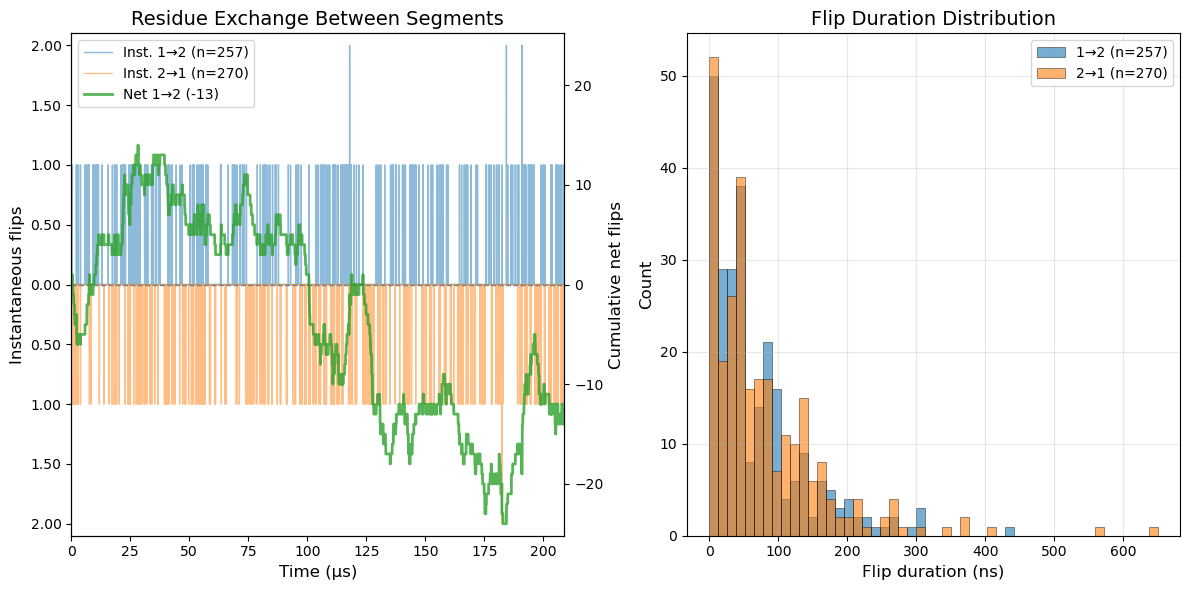

In [41]:
# Plot the result
analysis.plot(save='AB_flips.png', figsize=(12,6), running_average = 0, time_units=('mus', 'ns'))

In [43]:
help(analysis)

Help on ResidueExchangeAnalysis in module __main__ object:

class ResidueExchangeAnalysis(builtins.object)
 |  ResidueExchangeAnalysis(
 |      segmentation,
 |      segment_A=1,
 |      segment_B=2,
 |      blib_processing=True,
 |      dt=1,
 |      verbose=True
 |  )
 |
 |  Analysis class for tracking exchange/flips in particle traces between segment ID A and B.
 |
 |  This is a generalization of lipid flip-flops between two leaflets.
 |
 |  Usage:
 |      analysis = ResidueExchangeAnalysis(segmentation, segment_A=1, segment_B=2)
 |      analysis.compute()
 |      analysis.plot()
 |
 |  Methods defined here:
 |
 |  __init__(
 |      self,
 |      segmentation,
 |      segment_A=1,
 |      segment_B=2,
 |      blib_processing=True,
 |      dt=1,
 |      verbose=True
 |  )
 |      Initialize the analysis.
 |
 |      Parameters
 |      ----------
 |      segmentation : np.ndarray
 |          Segmentation data with shape (n_frames, n_traces)
 |      segment_A : int
 |          Segment I

<Residue OA, 1554>
Atom indices [7765 7766 7767 7768 7769]
Start Stop Duration Sign TraceID
[[ 5493  5494     0    -1  1553]
 [10367 10368     0     1  1553]
 [15703 15707     3    -1  1553]]


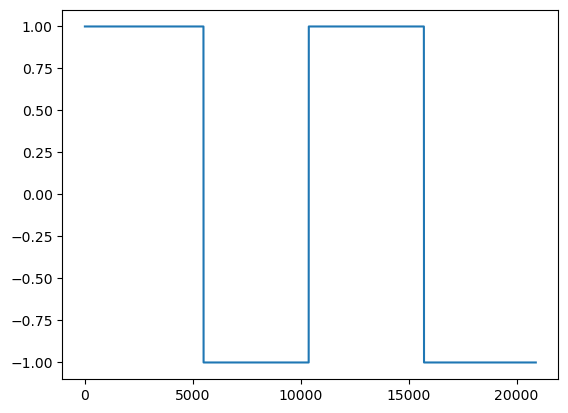

In [47]:
# Example to find a trace which flips the most
max_flips_trace = analysis.flip_counts[np.argmax(analysis.flip_counts[:,1])][0]
# Plot only the frames in which A and B are present for a max flip trace
plt.plot(analysis.masked_segmentation[:, max_flips_trace][analysis.valid_mask])
# Find the residue number for a most flipping particle
print(selection_atomgroup.residues[max_flips_trace])
print(f'Atom indices {selection_atomgroup.residues[max_flips_trace].atoms.ix}')
print('Start Stop Duration Sign TraceID')
print(analysis.flips[np.where(analysis.flips[:,4] == max_flips_trace)])

<Residue OA, 117109>
Atom indices [137548 137549 137550 137551 137552]
Start Stop Duration Sign TraceID
[[8508 8574   65    1 5110]]


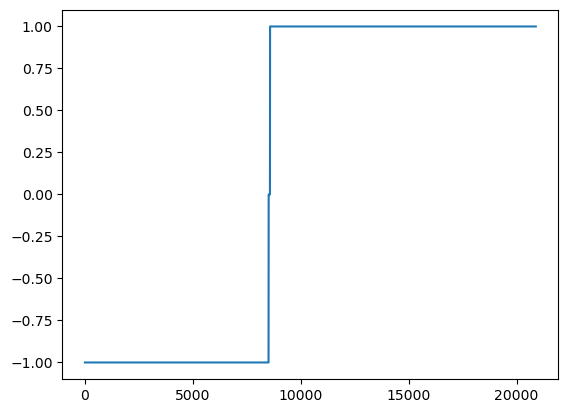

In [19]:
# Example to find a trace which flips the most
longest_flip_trace = analysis.flips[np.argmax(analysis.flips[:,2])][4]
# Plot only the frames in which A and B are present for a max flip duration trace
plt.plot(analysis.masked_segmentation[:, longest_flip_trace][analysis.valid_mask])
# Find the residue number for a longest flipping particle
print(selection_atomgroup.residues[longest_flip_trace])
print(f'Atom indices {selection_atomgroup.residues[longest_flip_trace].atoms.ix}')
print('Start Stop Duration Sign TraceID')
print(analysis.flips[np.where(analysis.flips[:,4] == longest_flip_trace)])

In [33]:
analysis.n_frames

20889